# 生還結果予測モデルの更新と更新前後の性能比較

In [1]:
import json
import aiohttp
import pandas as pd
from pprint import pprint

以下では更新用の学習データを作成します。
Webサービスでは"titanic.csv"の前半分を学習したモデルを初期化時に使用しているため、
その後半部分を更新用のデータ(`data_update`)として使用します。

In [2]:
# URL to the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
# Read data from the URL
data = pd.read_csv(url)
# Preprocess the data
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data = data.dropna()
data = data.sample(frac=1, random_state=342)
data_now = data.iloc[:len(data)//2]
data_update = data.iloc[len(data)//2:]

上記で作成した更新用データをモデル更新API(titanic/update)に入力します。
Webサービス側で更新用データをtrainデータを0.8、testデータを0.2の比率で分割して、
既存のtrainデータとtestデータにそれぞれマージします。
マージした新しい学習データでモデルの学習・評価を行った結果をAPIの出力(`metrics`)として得ます。

In [3]:
url_endpoint = "http://127.0.0.1:8000"
async with aiohttp.ClientSession(url_endpoint) as session:
    _input = data_update.to_dict('list')
    async with session.post("/titanic/update", json=_input) as response:
        result_str = await response.text()
metrics = json.loads(result_str)
# pprint(metrics)


In [6]:
keys_model = ["model", "model_old"]
keys_metric = ["precision", "recall", "f1_score", "average_precision", "accuracy"]
# keys_dataset = ["test", "test_add", "test_old"]
keys_dataset = ["test", "test_old"]
_pre_df = {"model": ["new", "old"]}
_pre_df.update({(k_dataset, k_metric): [metrics[k_model][k_dataset][k_metric]
                                         for k_model in keys_model]
                 for k_dataset in keys_dataset
                 for k_metric in keys_metric
                }
               )
df_metrics = pd.DataFrame(_pre_df)
# print(df_metrics.to_csv(float_format="%.3f", index=False, sep="\t"))
df_metrics

model  (test, precision)  (test, recall)  (test, f1_score)  \
0   new           0.758621        0.758621          0.758621   
1   old           0.716667        0.741379          0.728814   

   (test, average_precision)  (test, accuracy)  (test_old, precision)  \
0                   0.838467          0.805556               0.666667   
1                   0.839811          0.777778               0.625000   

   (test_old, recall)  (test_old, f1_score)  (test_old, average_precision)  \
0            0.714286              0.689655                       0.802202   
1            0.714286              0.666667                       0.809040   

   (test_old, accuracy)  
0              0.750000  
1              0.722222

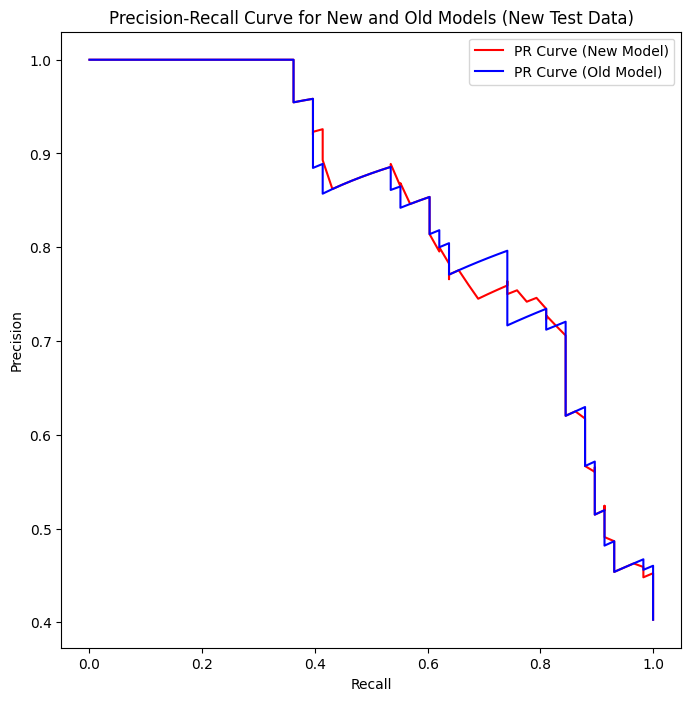

In [9]:
import matplotlib.pyplot as plt

k_dataset ="test"
precisions_new = metrics["model"][k_dataset]["pr_curve"]["precision"]
recalls_new = metrics["model_old"][k_dataset]["pr_curve"]["recall"]
precisions_old = metrics["model_old"][k_dataset]["pr_curve"]["precision"]
recalls_old = metrics["model_old"][k_dataset]["pr_curve"]["recall"]

plt.figure(figsize=(8, 8))
plt.plot(recalls_new, precisions_new, label=f'PR Curve (New Model)', color='r')
plt.plot(recalls_old, precisions_old, label=f'PR Curve (Old Model)', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for New and Old Models (New Test Data)')
plt.legend(loc='best')
plt.show()


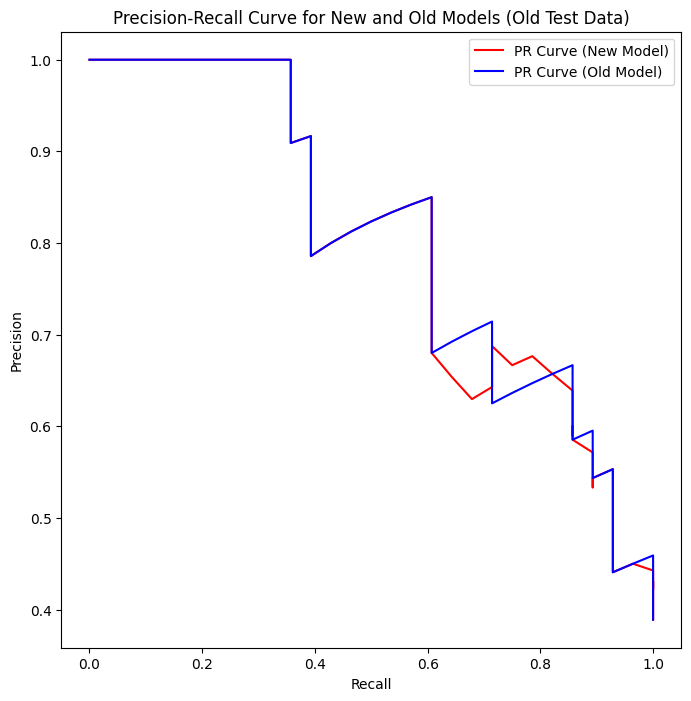

In [10]:
import matplotlib.pyplot as plt

k_dataset ="test_old"
precisions_new = metrics["model"][k_dataset]["pr_curve"]["precision"]
recalls_new = metrics["model_old"][k_dataset]["pr_curve"]["recall"]
precisions_old = metrics["model_old"][k_dataset]["pr_curve"]["precision"]
recalls_old = metrics["model_old"][k_dataset]["pr_curve"]["recall"]

plt.figure(figsize=(8, 8))
plt.plot(recalls_new, precisions_new, label=f'PR Curve (New Model)', color='r')
plt.plot(recalls_old, precisions_old, label=f'PR Curve (Old Model)', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for New and Old Models (Old Test Data)')
plt.legend(loc='best')
plt.show()